In [1]:
!git clone https://github.com/QLYoo/LFPNet
%cd LFPNet

Cloning into 'LFPNet'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 39 (delta 18), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (39/39), done.
/content/LFPNet


**Получаем TRIMAP**

In [2]:
CLASS_MAP = {"background": 0, "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5, "bus": 6, "car": 7,
             "cat": 8, "chair": 9, "cow": 10, "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
             "potted plant": 16, "sheep": 17, "sofa": 18, "train": 19, "tv/monitor": 20}

In [3]:
target_class = 'cat'
conf_threshold = 0.7

In [4]:
import os
import argparse
import torch
import numpy as np
from torchvision import transforms
import cv2

from PIL import Image
from io import BytesIO
from six.moves import urllib

import matplotlib.pyplot as plt

In [5]:
def trimap(probs, size, conf_threshold):
    """
    This function creates a trimap based on simple dilation algorithm
    Inputs [3]: an image with probabilities of each pixel being the foreground, size of dilation kernel,
    foreground confidence threshold
    Output    : a trimap
    """
    mask = (probs > 0.05).astype(np.uint8) * 255

    pixels = 2 * size + 1
    kernel = np.ones((pixels, pixels), np.uint8)

    dilation = cv2.dilate(mask, kernel, iterations=1)

    remake = np.zeros_like(mask)
    remake[dilation == 255] = 127  # Set every pixel within dilated region as probably foreground.
    remake[probs > conf_threshold] = 255  # Set every pixel with large enough probability as definitely foreground.

    return remake

In [6]:
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()
print('loaded')

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

loaded


In [7]:
SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://funart.pro/uploads/posts/2021-07/1626857468_3-funart-pro-p-sibirskaya-koshka-serebristaya-zhivotnie-k-3.jpg'  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
f = urllib.request.urlopen(image_url)
jpeg_str = f.read()
input_image = np.array(Image.open(BytesIO(jpeg_str)))

True

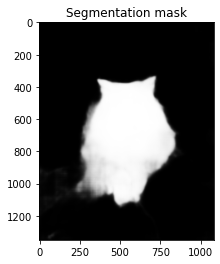

In [8]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

with torch.no_grad():
    output = model(input_batch)['out'][0]
    output = torch.softmax(output, 0)

output_cat = output[CLASS_MAP[target_class], ...].numpy()
plt.title('Segmentation mask')
plt.imshow(output_cat, cmap='gray', vmin=0, vmax=1)

trimap_image = trimap(output_cat, 7, conf_threshold)
cv2.imwrite('trimap.png', trimap_image)
cv2.imwrite('image.png', input_image)

**Подгружаем модель**

In [9]:
!gdown  https://drive.google.com/uc?id=1M3djMM_LULFE7_Ksg4kpQO3f46qAT7ay

Downloading...
From: https://drive.google.com/uc?id=1M3djMM_LULFE7_Ksg4kpQO3f46qAT7ay
To: /content/LFPNet/model.pth
100% 471M/471M [00:08<00:00, 55.3MB/s]


In [10]:
from eval import *
import torch
import torch.optim
import numpy as np
import argparse
import torch.nn as nn
import os
import cv2

In [11]:
import os
import  torch.nn.functional as F
import resnetws as resnet
from collections import OrderedDict
import layers as L


class ResnetDilatedINC(nn.Module):
    def __init__(self,inc=13, orig_resnet=resnet.l_resnet50(), dilate_scale=8,needinc=False):
        super(ResnetDilatedINC, self).__init__()
        from functools import partial

        if dilate_scale == 8:
            orig_resnet.layer3.apply(
                partial(self._nostride_dilate, dilate=2))
            orig_resnet.layer4.apply(
                partial(self._nostride_dilate, dilate=4))

        elif dilate_scale == 16:
            orig_resnet.layer4.apply(
                partial(self._nostride_dilate, dilate=2))

        if needinc:
            conv1 = orig_resnet.conv1
            conv1_weights=orig_resnet.conv1.weight
            c_out, c_in, h, w = conv1_weights.size()
            conv1_mod = torch.zeros(c_out, inc, h, w)
            conv1_mod[:, :3, :, :] = conv1_weights
            conv1.weight = torch.nn.Parameter(conv1_mod)
            conv1.in_channels = inc
            self.conv1 =conv1
        else:
            self.conv1 =orig_resnet.conv1
        self.bn1 = orig_resnet.bn1
        self.relu = orig_resnet.relu
        self.maxpool = orig_resnet.maxpool
        self.layer1 = orig_resnet.layer1
        self.layer2 = orig_resnet.layer2
        self.layer3 = orig_resnet.layer3
        self.layer4 = orig_resnet.layer4

    def _nostride_dilate(self, m, dilate):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            # the convolution with stride
            if m.stride == (2, 2):
                m.stride = (1, 1)
                if m.kernel_size == (3, 3):
                    m.dilation = (dilate // 2, dilate // 2)
                    m.padding = (dilate // 2, dilate // 2)
            # other convoluions
            else:
                if m.kernel_size == (3, 3):
                    m.dilation = (dilate, dilate)
                    m.padding = (dilate, dilate)

    def forward(self, x, return_feature_maps=False):
        conv_out = [x]
        x = self.relu(self.bn1(self.conv1(x)))
        conv_out.append(x)
        x, indices = self.maxpool(x)
        x = self.layer1(x)
        conv_out.append(x)
        x = self.layer2(x)
        conv_out.append(x)
        x = self.layer3(x)
        conv_out.append(x)
        x = self.layer4(x)
        conv_out.append(x)

        if return_feature_maps:
            return conv_out, indices
        return [x]



class _ImagePool(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv = _ConvBnReLU(in_ch, out_ch, 1, 1, 0, 1)

    def forward(self, x):
        _, _, H, W = x.shape
        h = self.pool(x)
        h = self.conv(h)
        h = F.interpolate(h, size=(H, W), mode="bilinear", align_corners=False)
        return h

class _ImagePoolEH(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv = _ConvBnReLU(in_ch, out_ch, 1, 1, 0, 1)

    def forward(self, x):
        _, _, H, W = x.shape
        h = self.pool(x)
        h = self.conv(h)
        h = F.interpolate(h, size=(H, W), mode="bilinear", align_corners=False)
        return h


class GNs_(nn.Module):
    def __init__(self,ch):
        super(GNs_, self).__init__()
        if ch%32==0 :
            g=32
        else:
            g=16
        self.gn=nn.GroupNorm(g,ch)
    def forward(self,x):
        return self.gn(x)


class _ConvBnReLU(nn.Sequential):
    def __init__(
            self, in_ch, out_ch, kernel_size, stride, padding, dilation, relu=True
    ):
        super(_ConvBnReLU, self).__init__()
        self.add_module(
            "conv",
            L.Conv2d(
                in_ch, out_ch, kernel_size, stride, padding, dilation, bias=False
            ),
        )
        self.add_module("bn", GNs_(out_ch))

        if relu:
            self.add_module("relu", nn.ReLU())

class _ConvBnReLUEH(nn.Sequential):
    def __init__(
            self, in_ch, out_ch, kernel_size, stride, padding, dilation, relu=True
    ):
        super(_ConvBnReLUEH, self).__init__()
        self.add_module(
            "conv",
            L.Conv2d(
                in_ch, out_ch, kernel_size, stride, padding, dilation, bias=True
            ),
        )
        self.add_module("bn", GNs_(out_ch))

        if relu:
            self.add_module("relu", nn.ReLU())

class _ASPPEH(nn.Module):
    def __init__(self, in_ch, out_ch, rates=[3, 7, 12 ,18]):
        super(_ASPPEH, self).__init__()
        self.stages = nn.Module()
        self.stages.add_module("c0", _ConvBnReLUEH(in_ch, out_ch, 1, 1, 0, 1))
        for i, rate in enumerate(rates):
            self.stages.add_module(
                "c{}".format(i + 1),
                _ConvBnReLUEH(in_ch, out_ch, 3, 1, padding=rate, dilation=rate),
            )
        self.stages.add_module("imagepool", _ImagePoolEH(in_ch, out_ch))

    def forward(self, x):
        return torch.cat([stage(x) for stage in self.stages.children()], dim=1)

class GResBlock0x(nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super(GResBlock0x, self).__init__()
        self.in_conv1 =  nn.Sequential(L.Conv2d(inplanes, planes,kernel_size=3, stride=stride,padding=1,bias=True),GNs_(planes))
        self.in_prelu1 = nn.Sequential(nn.LeakyReLU())
        self.basic_block1 = GBasicBlock(planes, planes, stride)
        self.basic_block2 = GBasicBlock(planes, planes, stride)
        self.ro_conv = nn.Sequential(L.Conv2d(planes, planes,kernel_size=3, stride=stride,padding=1,bias=True),GNs_(planes))
        self.ro_ = nn.LeakyReLU()
    def forward(self, x):
        out = self.in_conv1(x)
        out = self.in_prelu1(out)
        out_temp = out
        out = self.basic_block1(out)
        out = self.basic_block2(out)
        out = self.ro_conv(out)
        out += out_temp
        out=self.ro_(out)
        return out

class GBasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super(GBasicBlock, self).__init__()
        self.conv1 = L.Conv2d(inplanes, planes, kernel_size=3,stride=stride,padding=1,bias=True)
        self.prelu1 =  nn.Sequential(GNs_(planes),nn.LeakyReLU())
        self.conv2 = nn.Sequential(L.Conv2d(planes, planes,kernel_size=3, stride=stride,padding=1,bias=True),GNs_(planes))
        self.prelu2 =  nn.LeakyReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.prelu1(out)
        out = self.conv2(out)
        out += residual
        out = self.prelu2(out)
        return out


class PPMmoduleEH(nn.Module):
    def __init__(self, features, out_features=1024, sizes=(1, 2, 3, 6)):
        super().__init__()
        self.stages = []
        self.stages = nn.ModuleList([self._make_stage(features, size) for size in sizes])
        self.bottleneck = nn.Sequential(L.Conv2d(512 * (len(sizes)+1), out_features, kernel_size=1),nn.GroupNorm(32,out_features))
        self.relu = nn.ReLU()
        self.trans = L.Conv2d(features, 512, kernel_size=1)
    def _make_stage(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Sequential(L.Conv2d(features, 512, kernel_size=1, bias=True),nn.GroupNorm(32,512))
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.upsample(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.stages] + [self.trans(feats) ]
        bottle = self.bottleneck(torch.cat(priors, 1))
        return self.relu(bottle)


def fba_fusion(alpha, img, F, B):
    F = ((alpha * img + (1 - alpha**2) * F - alpha * (1 - alpha) * B))
    B = ((1 - alpha) * img + (2 * alpha - alpha**2) * B - alpha * (1 - alpha) * F)
    F = torch.clamp(F, 0, 1)
    B = torch.clamp(B, 0, 1)
    la = 0.1
    alpha = (alpha * la + torch.sum((img - B) * (F - B), 1, keepdim=True)) / (torch.sum((F - B) * (F - B), 1, keepdim=True) + la)
    alpha = torch.clamp(alpha, 0, 1)
    return alpha, F, B


class SEB(nn.Module):
    def __init__(self,inc,oc):
        super(SEB, self).__init__()
        self.c=nn.Sequential(nn.Conv2d(inc,inc,1,1,0),nn.ReLU(),nn.Conv2d(inc,oc,1,1,0),nn.Sigmoid())
    def forward(self,x,y):
        y_=torch.cat([x,y],1)
        y_=self.c(y_)
        x=x*y_
        return x


class LFPNet(nn.Module):
    def __init__(self):
        super(LFPNet, self).__init__()
        self.resnet_stem=nn.Sequential(nn.Upsample(scale_factor=0.5,mode='bicubic',align_corners=True),nn.Conv2d(12, 16, kernel_size=5, stride=2, padding=2, bias=True),nn.GroupNorm(8,16),nn.LeakyReLU())
        self.resnet=ResnetDilatedINC(16,dilate_scale=8,needinc=True)
        self.se1=SEB(2048+1024,2048)
        self.setensor=nn.Parameter(torch.randn(1,1024,1,1))
        self.rppm=PPMmoduleEH(2048,512)
        self.aspp=_ASPPEH(2048+512,256)
        self.resnet1=nn.Sequential((L.Conv2d(256*6, 256, kernel_size=3, stride=1, padding=1, bias=True)),nn.GroupNorm(32,256),nn.LeakyReLU())
        self.presnet2=nn.Sequential( (L.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)),nn.GroupNorm(32,256),nn.LeakyReLU())
        self.resnet2=nn.Sequential( (L.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, bias=True)),nn.GroupNorm(32,256),nn.LeakyReLU())
        self.resnet3=nn.Sequential((L.Conv2d(320, 128, kernel_size=3, stride=1, padding=1, bias=True)),nn.GroupNorm(16,128),nn.LeakyReLU())
        self.resnet4=nn.Sequential( L.Conv2d(128+16, 64, kernel_size=3, stride=1, padding=1, bias=True),nn.GroupNorm(16,64),nn.LeakyReLU())
        self.oesnet5=nn.Sequential( (L.Conv2d(64+16, 64, kernel_size=3, stride=1, padding=1, bias=True)),nn.GroupNorm(16,64),nn.LeakyReLU())
        self.stem_conv = nn.Sequential( L.Conv2d(12, 32, kernel_size=3, stride=1, padding=1, bias=True),
                                        nn.GroupNorm(16, 32), nn.ReLU()
                                       )
        self.pre_conv = nn.Sequential( L.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=True),nn.GroupNorm(16, 64),)
        self.pre_prelu = nn.ReLU()
        self.res1 = nn.Sequential(L.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True),nn.GroupNorm(32,64),nn.ReLU())
        self.ds1 = nn.Sequential((L.Conv2d(64,64,3,2,1,bias=True)),nn.GroupNorm(32,64),nn.ReLU())
        resnet2 = ResnetDilatedINC(dilate_scale=8)
        self.res2 = resnet2.layer1
        self.res3 = resnet2.layer2
        self.res4 = resnet2.layer3
        self.res5 = resnet2.layer4
        self.res2c = nn.Sequential(L.Conv2d(128,64,1,1,0,bias=True),nn.GroupNorm(32,64),nn.ReLU())
        self.res3c = nn.Sequential(L.Conv2d(512+128,512,1,1,0,bias=True),nn.GroupNorm(32,512),nn.ReLU())
        pool_scales = (1, 2, 3, 6,1,2)
        self.ppm = []
        for scale in pool_scales:
            self.ppm.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(scale),
                (L.Conv2d(2048, 256, kernel_size=1, bias=True)),
                GNs_(256),
                nn.LeakyReLU()
            ))
        self.ppm = nn.ModuleList(self.ppm)
        self.res44 = nn.Sequential( L.Conv2d(3072+512,512,3, 1, 1, 1, bias=True),nn.GroupNorm(32,512),nn.LeakyReLU(),GResBlock0x(512,512))
        self.res33 = nn.Sequential( GResBlock0x(1024,256))
        self.ups3 = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=False)
        self.res22 = nn.Sequential(GResBlock0x(512,128))
        self.ups2 = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=False)
        self.res11 = nn.Sequential(L.Conv2d(128+64, 64, kernel_size=3, stride=1, padding=1, bias=True),nn.GroupNorm(32,64),nn.LeakyReLU())
        self.ups1 =  nn.Upsample(scale_factor=2,mode='bilinear',align_corners=False)
        self.out_ups = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=False)
        self.out_conv3 =( nn.Conv2d(64+3+3+3, 32, kernel_size=3, stride=1, padding=1, bias=True))
        self.out_prelu3 = nn.PReLU(32)
        self.out_conv2 = (nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=True))
        self.out_prelu2 = nn.PReLU(16)
        self.out_conv1 =nn.Sequential((nn.Conv2d(16, 7, kernel_size=1, stride=1, padding=0, bias=True)))

    def forward(self, x,xbig,raw):
        x_=self.resnet_stem(xbig)
        feat,idx=self.resnet(x_,True)
        b,_,_,_=x.shape
        setensor=torch.reshape(self.setensor,[b,1024,1,1])
        setensor=torch.nn.functional.interpolate(setensor, (feat[-1].shape[2], feat[-1].shape[3]),mode='bilinear',align_corners=False)
        featz=self.se1(feat[-1],setensor)
        feat1p=self.rppm(featz)
        feat1=torch.cat([featz,feat1p],1)
        feat1=self.aspp(feat1)
        feat1=self.resnet1(feat1)
        feat2=torch.nn.functional.interpolate(feat1,scale_factor=2,mode='bilinear',align_corners=False)
        featr2=self.presnet2(feat[-4])
        feat2=torch.cat([feat2,featr2],1)
        feat3=self.resnet2(feat2)
        feat3=torch.nn.functional.interpolate(feat3,scale_factor=2,mode='bilinear',align_corners=False)
        feat3=torch.cat([feat3,feat[-5]],1)
        feat3=self.resnet3(feat3)
        feat4=torch.nn.functional.interpolate(feat3,scale_factor=2,mode='bilinear',align_corners=False)
        feat4=torch.cat([feat4,feat[-6]],1)
        feat4=self.resnet4(feat4)
        feat5=torch.cat([feat4,x_],1)
        feat5_=self.oesnet5(feat5)
        _,_,feat5_h,feat5_w=feat5_.shape
        feat5_=feat5_[:,:,feat5_h//4: feat5_h//4+feat5_h//2 ,feat5_w//4: feat5_w//4+feat5_w//2]
        _,_,feat5_h,feat5_w=feat3.shape
        feat3=feat3[:,:,feat5_h//4: feat5_h//4+feat5_h//2 ,feat5_w//4: feat5_w//4+feat5_w//2]
        pre_ = self.stem_conv(x)
        pre = self.pre_conv(pre_)
        pre = self.pre_prelu(pre)
        resc1 = self.res1(pre)
        down1 = self.ds1(resc1)
        down1=self.res2c( torch.cat([down1,feat5_],1))
        resc2 = self.res2(down1)
        resc3 = self.res3(resc2)
        down3 =   self.res3c( torch.cat([resc3,feat3],1))
        resc4 = self.res4(down3)
        resc5 = self.res5(resc4)
        ppm_out = [resc5]
        for pool_scale in self.ppm:
            ppm_out.append(nn.functional.interpolate(
                pool_scale(resc5),
                (resc5.shape[2], resc5.shape[3]),
                mode='bilinear', align_corners=False))
        ppm_out = torch.cat(ppm_out, 1)
        ppm_out=(ppm_out)
        upres4 = self.res44(ppm_out)
        up3 = upres4
        merge3 = torch.cat([up3, resc3], dim=1)
        upres3 = self.res33(merge3)
        up2 = self.ups2(upres3)
        merge2 = torch.cat([up2, resc2], dim=1)
        upres2 = self.res22(merge2)
        up1 = self.ups1(upres2)
        merge1 = torch.cat([up1, resc1], dim=1)
        upres1 = self.res11(merge1)
        up0 = self.out_ups(upres1)
        merge0 = torch.cat([up0, raw,x[:,3:6],x[:,0:3]], dim=1)
        out = self.out_conv3(merge0)
        out = self.out_prelu3(out)
        out = self.out_conv2(out)
        out = self.out_prelu2(out)
        out = self.out_conv1(out)
        alpha = torch.clamp(out[:, 0:1], 0, 1)
        F = torch.clamp(out[:, 1:4],0,1)
        B = torch.clamp(out[:, 4:7],0,1)
        alpha, F, B=fba_fusion(alpha,raw, F, B)
        output = torch.cat((alpha, F, B), 1)
        return output


In [ ]:
IMG_SCALE = 1. / 255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))
segmodel = model.LFPNet()
segmodel.load_state_dict(torch.load('model.pth',map_location='cpu'),strict=False)
segmodel=segmodel.cuda()
segmodel.eval()

In [16]:
img=cv2.imread('image.png')
raw_h,raw_w,_=img.shape
alphaall=np.zeros((raw_h,raw_w),np.float32)
img = cv2.imread('image.png')
h1_, w1_, _ = img.shape
psss=512
qsss=1024-512
wsss=qsss+psss
wsss2=wsss//2
wx=(w1_-1-psss) //qsss+1
hx=(h1_-1-psss) //qsss+1
alphalist=[]
newh=hx*qsss+psss
neww=wx*qsss+psss
raw_h, raw_w, _ = img.shape
imgzys=img.copy()
alls=[]
alltri=[]
ph1=(newh-raw_h)//2
ph2=newh-raw_h-ph1
pw1=(neww-raw_w)//2
pw2=neww-raw_w-pw1
allp=set(list(np.arange(0,16)))
tp = np.zeros((newh, neww,16), np.float32)
wp = np.zeros((newh, neww, 16), np.float32)
apPP = np.zeros((newh, neww, 16), np.float32)
allp = set(list(np.arange(0, 16)))
wsm = genwmap(qsss, psss)
for x11 in [0]:
    for y11 in [0]:
        pwh=[0,0,0,0]
        pwh=[ph1,ph2,pw1,pw2]
        imgbp = cv2.copyMakeBorder(imgzys, pwh[0], pwh[1], pwh[2], pwh[3], cv2.BORDER_REPLICATE)
        tri = trimap_image
        trizys=tri.copy()
        tribp = cv2.copyMakeBorder(tri, pwh[0], pwh[1], pwh[2], pwh[3], cv2.BORDER_CONSTANT)
        imgbpp=cv2.copyMakeBorder(imgbp, wsss2,wsss2,wsss2,wsss2, cv2.BORDER_REPLICATE)
        tribpp=cv2.copyMakeBorder(tribp, wsss2,wsss2,wsss2,wsss2, cv2.BORDER_CONSTANT)
        alls = []
        for px in range(hx):
            for py in range(wx):
                nnns=0
                for zzz in range(16):
                    if np.sum(tp[px*qsss:px*qsss+wsss,py*qsss:py*qsss+wsss,zzz])==0:
                        nnns=zzz
                        break
                wp[px*qsss: px*qsss+wsss, py*qsss:py*qsss+wsss,nnns]=wsm
                tp[px*qsss:px*qsss+wsss,py*qsss:py*qsss+wsss,nnns] = 1
                alls = []
                for fl1, fl2 in zip([0], [0]):
                    if fl1 >= 0:
                        imgf = imgbp[px * qsss:px * qsss + wsss, py * qsss:py * qsss + wsss].copy()
                        trif = tribp[px * qsss:px * qsss + wsss, py * qsss:py * qsss + wsss].copy()
                        imgrr = cv2.flip(imgf, fl1)
                        trirr = cv2.flip(trif, fl1)
                        imgss2=cv2.flip(imgzys.copy(), fl1)
                        triss2=cv2.flip(trizys.copy(), fl1)
                        img4x2 = imgbpp[px*qsss:(px)*qsss+wsss+wsss,py*qsss:(py)*qsss+wsss+wsss].copy()
                        tri4x2 = tribpp[px*qsss:(px)*qsss+wsss+wsss,py*qsss:(py)*qsss+wsss+wsss].copy()
                        img4x2 = cv2.flip(img4x2, fl1)
                        tri4x2 = cv2.flip(tri4x2, fl1)
                    else:
                        imgf = imgbp[px * qsss:px * qsss + wsss, py * qsss:py * qsss + wsss].copy()
                        trif = tribp[px * qsss:px * qsss + wsss, py * qsss:py * qsss + wsss].copy()
                        imgrr = imgf.copy()
                        trirr = trif.copy()
                        imgss2 = imgzys.copy()
                        triss2 = trizys.copy()
                        img4x2 = imgbpp[px*qsss:(px)*qsss+wsss+wsss,py*qsss:(py)*qsss+wsss+wsss].copy()
                        tri4x2 = tribpp[px*qsss:(px)*qsss+wsss+wsss,py*qsss:(py)*qsss+wsss+wsss].copy()
                    for fr1, fr2 in zip([0], [2]):
                        if fr1 >= 0:
                            imgrr3 = cv2.rotate(imgrr.copy(), fr1)
                            trirr3 = cv2.rotate(trirr.copy(), fr1)
                            imgss3 = cv2.rotate(imgss2.copy(), fr1)
                            triss3 = cv2.rotate(triss2.copy(), fr1)
                            img4x3 = cv2.rotate(img4x2.copy(), fr1)
                            tri4x3 = cv2.rotate(tri4x2.copy(), fr1)
                        else:
                            imgrr3= imgrr.copy()
                            trirr3= trirr.copy()
                            imgss3= imgss2.copy()
                            triss3= triss2.copy()
                            img4x3=img4x2.copy()
                            tri4x3=tri4x2.copy()
                        img=imgrr3
                        tri=trirr3
                        imgss=imgss3
                        triss=triss3
                        img4x=img4x3
                        tri4x=tri4x3
                        tritemp = np.zeros([*tri.shape, 2], np.float32)
                        tritemp[:, :, 0] = (tri == 0)
                        tritemp[:, :, 1] = (tri == 255)
                        sixc = trimap_transform(tritemp)
                        sixc = np.transpose(sixc, [2, 0, 1])
                        tritemp = np.zeros([*tri4x.shape, 2], np.float32)
                        tritemp[:, :, 0] = (tri4x == 0)
                        tritemp[:, :, 1] = (tri4x == 255)
                        sixc4x = trimap_transform(tritemp)
                        sixc4x = np.transpose(sixc4x, [2, 0, 1])
                        h_, w_ = tri.shape
                        tri2 = np.array(tri, np.float32) / 255.
                        tri2 = tri2[np.newaxis, np.newaxis, :, :]
                        tri24x = np.array(tri4x, np.float32) / 255.
                        tri24x = tri2[np.newaxis, np.newaxis, :, :]
                        mattinginput = ((img[:, :, ::-1] / 255.) - IMG_MEAN) / IMG_STD
                        mattinginput4x = ((img4x[:, :, ::-1] / 255.) - IMG_MEAN) / IMG_STD
                        raw = img[:, :, ::-1] / 255.
                        raw = np.transpose(raw, [2, 0, 1])[None, :, :, :]
                        h_, w_ = tri.shape
                        trixs = np.zeros((1, 3, h_, w_), np.float32)
                        trixs[0, 0] = (tri == 0)
                        trixs[0, 1] = (tri == 128)
                        trixs[0, 2] = (tri == 255)
                        ntrixs = trixs
                        trixs = torch.from_numpy(trixs)
                        h_, w_ = tri4x.shape
                        tris4x = np.zeros((1, 3, h_, w_), np.float32)
                        tris4x[0, 0] = (tri4x == 0)
                        tris4x[0, 1] = (tri4x == 128)
                        tris4x[0, 2] = (tri4x == 255)
                        tris4x = torch.from_numpy(tris4x)
                        mattinginput = np.transpose(mattinginput, (2, 0, 1)).astype(np.float32)
                        mattinginput = np.array(mattinginput)[np.newaxis, :, :, :]
                        mattinginput4x = np.transpose(mattinginput4x, (2, 0, 1)).astype(np.float32)
                        mattinginput4x = np.array(mattinginput4x)[np.newaxis, :, :, :]
                        i1 = torch.from_numpy(mattinginput)
                        i2 = torch.from_numpy(mattinginput4x)
                        sixc = sixc[None, :, :, :]
                        sixc4x = sixc4x[None, :, :, :]
                        sixc2 = torch.from_numpy(sixc)
                        sixc24x = torch.from_numpy(sixc4x)
                        i2i = torch.cat([i2, tris4x, sixc24x], 1).float().cuda()
                        i1i = torch.cat([i1, trixs, sixc2], 1).float().cuda()
                        rawi = torch.from_numpy(raw).float().cuda()
                        with torch.no_grad():
                            preda= segmodel(i1i, i2i, rawi)
                        preda = preda.detach().cpu()
                        ap = preda[0, 0].numpy() * ntrixs[0, 1] + ntrixs[0, 2]
                        a1 = ap
                        if fr2 >= 0:
                            a1 = cv2.rotate(a1, fr2)
                        if fl2 >= 0:
                            a1 = cv2.flip(a1, fl2)
                        alls.append(a1)
                a1 = np.array(sum(alls) * 255. / len(alls))
                alls=[]
                apPP[px * qsss:px * qsss + wsss, py * qsss:py * qsss + wsss,nnns] = a1
palpha=np.sum(apPP*wp,2)/ np.sum(wp,2)
palpha=np.clip(palpha,0,255)
palpha=np.array(palpha,np.uint8)
wholealpha=palpha[ph1:ph1+raw_h,pw1:pw1+raw_w]
wholealpha[trizys==0]=0
wholealpha[trizys==255]=255

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desir

In [33]:
alpha = np.clip(preda[0, :1].detach().cpu().numpy(), 0,255)

In [35]:
alpha.squeeze()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.00470898,
        0.007916  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01223631,
        0.00175705],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01803128, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

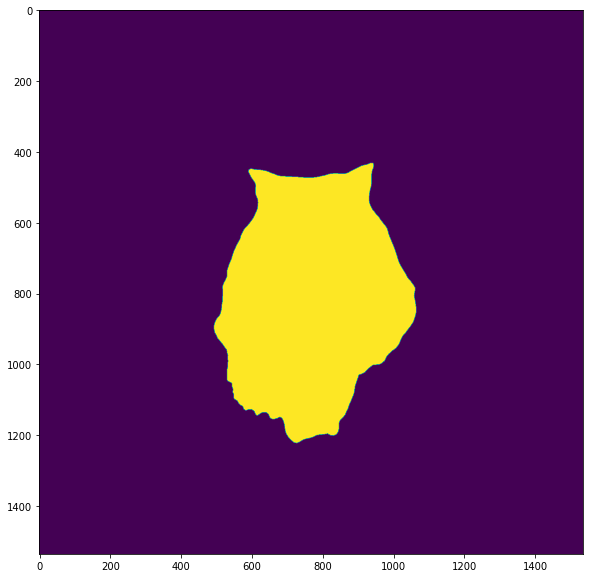

In [37]:
plt.figure(figsize=(10, 10))
plt.imshow(palpha)
plt.show()

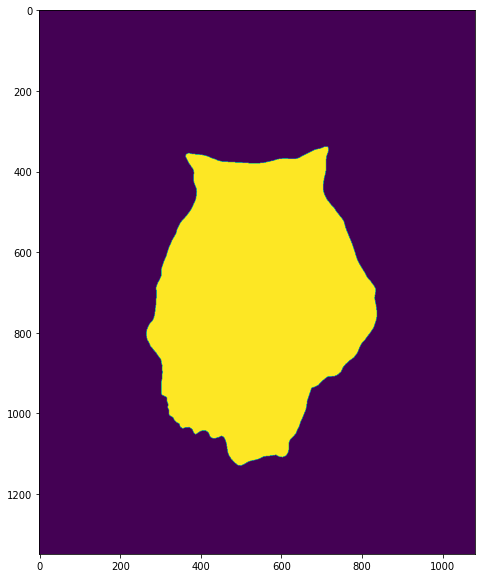

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(wholealpha)
plt.show()